<a href="https://colab.research.google.com/github/menna-ibrahim/Lane-Detection/blob/main/Lane_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import scipy as sp
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from scipy import signal
import math

## **Canny Edge Detection**

In [ ]:
def edge_detection(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  smooth_image = cv2.medianBlur(img,7)
  edge_img = cv2.Canny(smooth_image,100,200)
  return edge_img

In [ ]:
def roi(img):
  img[0:320,:]=0
  img[:,1000:]=0
  return img

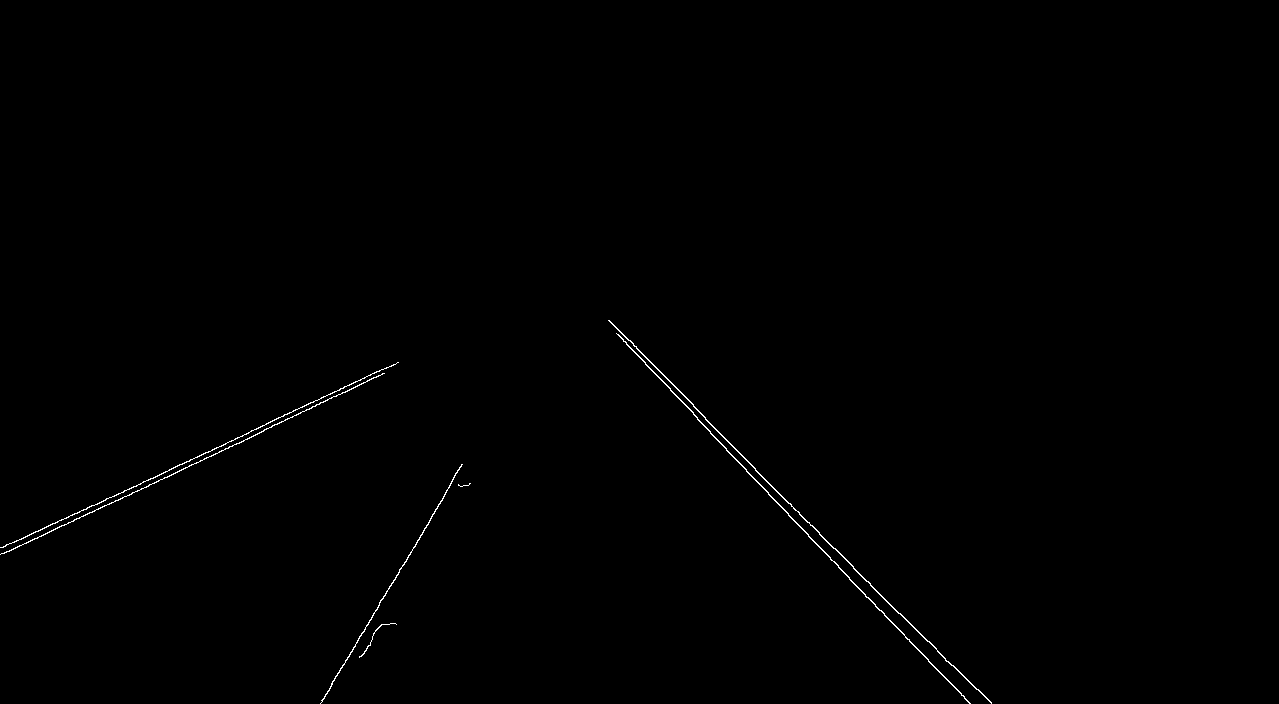

In [ ]:
edge_img = roi(edge_detection(road_image))
cv2_imshow(edge_img)

## **Hough Transform**

In [ ]:
def hough_transform(edge_img):
  non_zeros = np.nonzero(edge_img)
  dict_hough = {}
  diagonal = math.ceil(math.sqrt(edge_img.shape[0]**2 + edge_img.shape[1]**2))
  for x,y in zip(non_zeros[0],non_zeros[1]):
    for theta in range(0,180):
      row = round(x*math.cos(theta*math.pi/180) + y*math.sin(theta*math.pi/180))+diagonal
      if(row,theta) in dict_hough.keys():
        dict_hough[(row,theta)]=dict_hough[(row,theta)]+1
      else:
        dict_hough[(row,theta)]=1
  return dict_hough

In [ ]:
dict_hough = hough_transform(edge_img)

In [ ]:
values = np.array(list(dict_hough.values()))
print(f"Maximum value = {np.max(values)}")
print(f"Median value = {np.median(values)}")
print(f"Mean value = {np.mean(values)}")

Maximum value = 346
Median value = 4.0
Mean value = 4.8476692862525566


In [ ]:
diagonal = math.ceil(math.sqrt(edge_img.shape[0]**2 + edge_img.shape[1]**2))
accumulated_array = np.zeros(shape=(diagonal*2,180))

In [ ]:
for element in dict_hough.keys():
  accumulated_array[element[0]][element[1]] = dict_hough[element]

In [ ]:
print(len(dict_hough.keys()))
print(len(np.nonzero(accumulated_array)[0]))

111468
111468


In [ ]:
accumulated_array[accumulated_array<50]=0
print(len(np.nonzero(accumulated_array)[0]))

148


## **Non Maxima Suppression**

In [ ]:
#range = 100 x 10
#non-maximum supression
i = 0
j = 0
shift_in_i = 100
shift_in_j = 10
m1 = accumulated_array.shape[0]
m2 = accumulated_array.shape[1]
counter=0
while(i<m1):
  j=0
  while(j<m2):
    max = np.max(accumulated_array[i:min(i+shift_in_i,m1),j:min(j+shift_in_j,m2)])
    max_coordinates = np.where(accumulated_array[i:min(i+shift_in_i,m1),j:min(j+shift_in_j,m2)]==max)
    accumulated_array[i:min(i+shift_in_i,m1),j:min(j+shift_in_j,m2)] = 0
    accumulated_array[i:min(i+shift_in_i,m1),j:min(j+shift_in_j,m2)][max_coordinates[0][0],max_coordinates[1][0]] = max
    j = j+shift_in_j
  i += shift_in_i

In [ ]:
len(np.nonzero(accumulated_array)[0])

6

## **Drawing Lines**

In [ ]:
def draw_lines(img):
  nonzeros_indices = np.nonzero(accumulated_array)
  for row,theta in zip(nonzeros_indices[0],nonzeros_indices[1]):
    row = row - diagonal
    theta = theta * math.pi / 180
    sine = math.sin(theta)
    cosine = math.cos(theta)
    xo = row * cosine
    yo = row * sine
    x1 = round(xo - 2000 * sine)
    y1 = round(yo + 2000 * cosine)
    x2 = round(xo + 2000 * sine)
    y2 = round(yo - 2000 * cosine)
    img = cv2.line(img, (y1,x1), (y2,x2), (255, 0, 0) , 2)
  return img

In [ ]:
road_image = cv2.imread("road.jpg")
lined_image = draw_lines(road_image)
final_image = cv2.imread("road.jpg")
lined_image[0:320,:] = final_image[0:320,:]

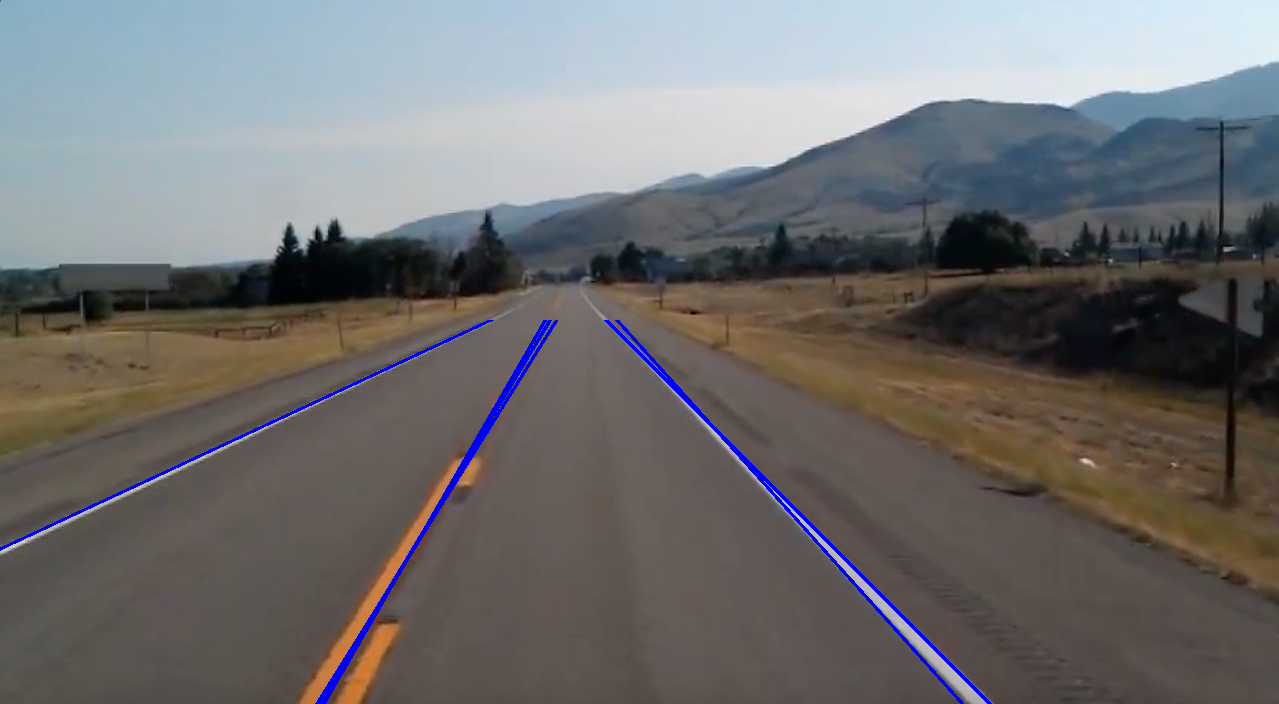

In [ ]:
cv2_imshow(lined_image)